Notebook used to develop and troubleshoot `get_curvature` and `get_generalized_curvature` functions. Resulted in some visualizations (below) that confirmed that functions work properly at least for 2d curves.

In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload

In [136]:
import numpy as np
import scipy.io as sio
import sklearn as sk
from sklearn import decomposition
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import datetime
import pickle
import os
import pprint
import numpy.polynomial.polynomial as P
from mpl_toolkits.mplot3d import Axes3D
from cycling_rnn import *

In [ ]:
#cmap = sns.color_palette('RdBu',5)[:2] + sns.color_palette('RdBu',5)[-2:]
#sns.set_palette(cmap)
sns.set_context('paper', font_scale=1.5)

# curvature method 1
Naive approach. Fit a circle to 3 points (basic geometry problem). Then calculate the curvature from there. This should work poorly for noisy data, *but* is basically guarunteed to be correct for smooth, noise-free data, and can be useful for sanity checking when developing other methods.

In [126]:
n = 2 # dimensions

# 3 points, a b c
A = np.random.randn((n))
B = np.random.randn((n))
C = np.random.randn((n))

In [127]:
# some cross-product identities
def cross_id1(a,b,c):
    return np.dot(a,c)*b - np.dot(a,b)*c

def cross_id2(a,b):
    return np.sqrt(np.linalg.norm(a)**2*np.linalg.norm(b)**2 - np.dot(a,b)**2)

In [128]:
a = A-C
b = B-C

In [129]:
r = np.linalg.norm(a)*np.linalg.norm(b)*np.linalg.norm(a-b)/(2*cross_id2(a,b))
p = cross_id1(np.linalg.norm(a)**2*b - np.linalg.norm(b)**2*a, a, b)/(2*cross_id2(a,b)**2) + C

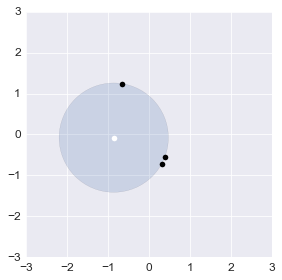

1.33578115706


In [130]:
plt.figure()
ax = plt.gca()
circle1 = plt.Circle((p[0], p[1]), r, alpha=0.2)
ax.add_artist(circle1)


plt.plot(A[0],A[1],'ko')
plt.plot(B[0],B[1],'ko')
plt.plot(C[0],C[1],'ko')
plt.plot(p[0],p[1],'wo')

plt.axis('square')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

plt.show()
print r

# curvature method 2
Better method that allows us to calculate generalized curvature as well (torsion, etc). Result of this testing ended up in `get_generalized_curvature`

In [131]:
def rand_signal(time_, cycle_, components_):
    """ 
    Create a size (T,) signal with lognormal distribution of component frequencies.
    """
    freq = 2*np.pi/cycle_*np.random.lognormal(mean=0, size=components_)
    phi = np.random.rand(components_)*cycle_
    z = np.sin(np.outer(time_, freq) + phi)
    z = z.sum(axis=1) # add up the sinusoids 
    z = (z - z.min()) / (z.max() - z.min()) # normalize
    z = 2*z - 1 # set range to [-1,1]
    return z

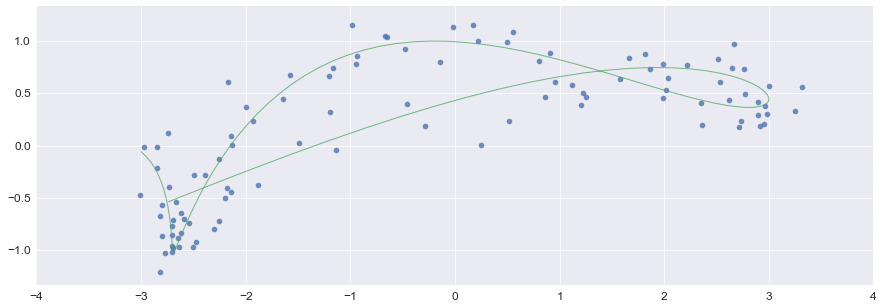

In [134]:
# make a random signal/trajectory with noise
n = 2
t = 100
time = np.linspace(0., .5, t)

tmid = time[t/2]

points = np.zeros((t, n))
points_true = np.zeros((t, n))
for nn in range(n):
    points_true[:, nn] = (3-nn*2)*rand_signal(time, 1, 10)
points = points_true + 0.15*np.random.randn(t, n)

fig = plt.figure(figsize=(15,5))
if n>2:
    ax = fig.gca(projection='3d')
    plt.plot(points[:,0] ,points[:,1], points[:,2], 'o', linewidth=0.5, alpha=0.8)
    plt.plot(points_true[:,0] ,points_true[:,1], points_true[:,2], '-', linewidth=1.5, alpha=0.8)
else:
    plt.plot(points[:,0] ,points[:,1], 'o', linewidth=0.5, alpha=0.8)
    plt.plot(points_true[:,0] ,points_true[:,1], '-', linewidth=1, alpha=0.8)
plt.axis('equal')
plt.show()

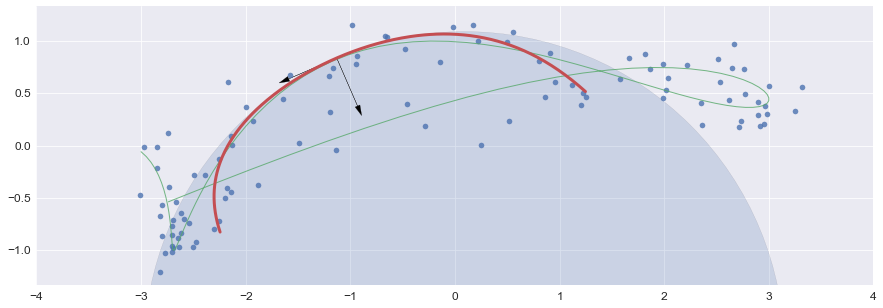

In [135]:
tref = 58 # reference point, i.e. where to calculate curvature

total_points = 30
deg = 4
k, e = get_generalized_curvature(points, total_points, deg)

total_curvatures = np.min((points.shape[1]-1, deg-1)) # have many curvatures to calculate

half = np.floor(total_points/2).astype(int)

times = np.arange(tref-half, tref+half+1)
times_local = times - tref # will always be -half:half
tmid = times_local[half] # tmid = 0
p = P.polyfit(times_local, points[times], deg)
pt = P.polyval(tmid, p)

times_plot = np.linspace(times_local[0], times_local[-1], 10*total_points)
p_plot = P.polyval(times_plot, p)

plt.figure(figsize=(15,5))
ax = plt.gca()

circle1 = plt.Circle(pt+1/k[tref,0]*e[tref][:,1], 1/k[tref,0], alpha=0.2)
ax.add_artist(circle1)

plt.plot(points[:,0], points[:,1],  'o', linewidth=1, alpha=0.8)
plt.plot(points_true[:,0], points_true[:,1],  '-', linewidth=1, alpha=0.8)
plt.plot(p_plot.T[:,0], p_plot.T[:,1], linewidth=3)

ax.arrow(pt[0], pt[1], 0.5*e[tref][0,0], 0.5*e[tref][1,0], head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.arrow(pt[0], pt[1], 0.5*e[tref][0,1], 0.5*e[tref][1,1], head_width=0.05, head_length=0.1, fc='k', ec='k')

plt.axis('equal')
#plt.xlim([-2, 2])
#plt.ylim([-2, 2])

plt.show()